notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

import sys
sys.path.append("../")
from create_arrays import siiv

In [2]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h373_sub2min.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h373_sub2min_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [3]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.1s)
line = 1402.77

../create_arrays.py:70: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
../create_arrays.py:130: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
../create_arrays.py:184: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


(1402.0, 1404.0)

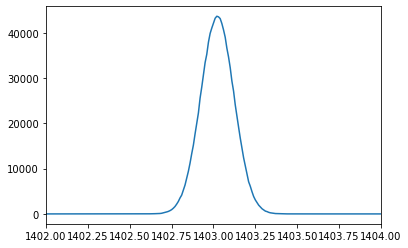

In [4]:
k = 115
arrs = siiv(tube,frac,log10T,log10G,time=k)
plt.plot(arrs.wav,arrs.spec)
plt.xlim(1402,1404)

In [5]:
ll = arrs.wav

In [6]:
arrs.rebin()

reshape index =  20


../create_arrays.py:70: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
../create_arrays.py:130: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
../create_arrays.py:184: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


number of time elements after rebin:  30


Text(0.5, 0, 'wavelength [$\\AA$]')

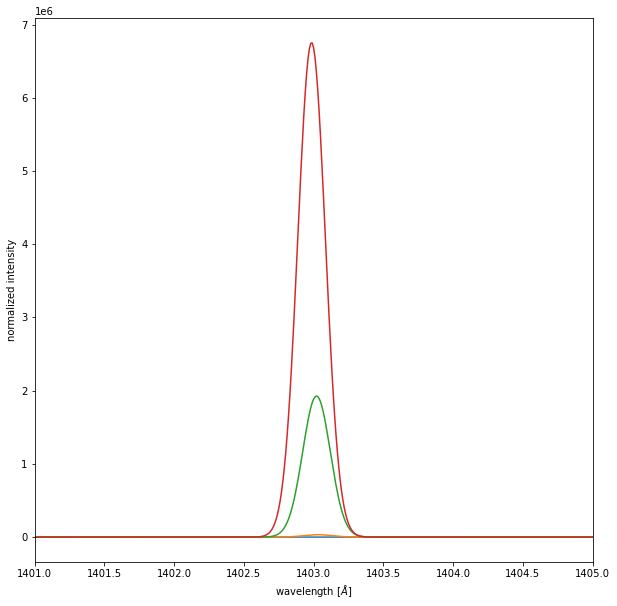

In [7]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,arrs.respec[4,:])
plt.plot(ll,arrs.respec[5,:])
plt.plot(ll,arrs.respec[6,:])
plt.plot(ll,arrs.respec[7,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [8]:
arrs.respec.shape

(30, 2000)

# Time series of synthetic spectrum:

In [9]:
arrs.fitspec()

nt =  30


(0.0, 60.0)

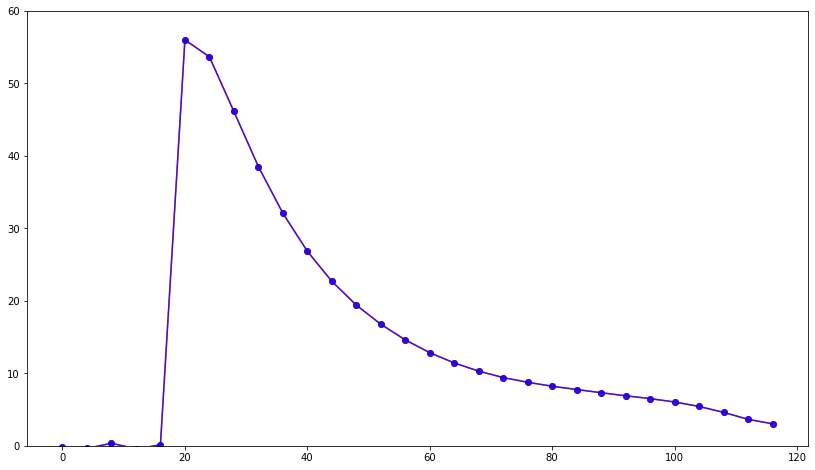

In [10]:
plt.figure(figsize=(14,8))
plt.plot(arrs.time,arrs.vr,'r',alpha=0.75,marker='o')
plt.plot(arrs.time,arrs.vb,'b',alpha=0.75,marker='o')
plt.ylim(0,60)

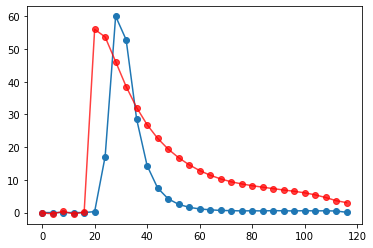

In [11]:
plt.plot(arrs.time,arrs.amp/np.max(arrs.amp)*60,marker='o')
plt.plot(arrs.time,arrs.vr,'r',alpha=0.75,marker='o')

In [12]:
i_max = np.argmax(arrs.amp)
shift_time = arrs.time[i_max]#-61454.63

In [13]:
shift_time

28.0

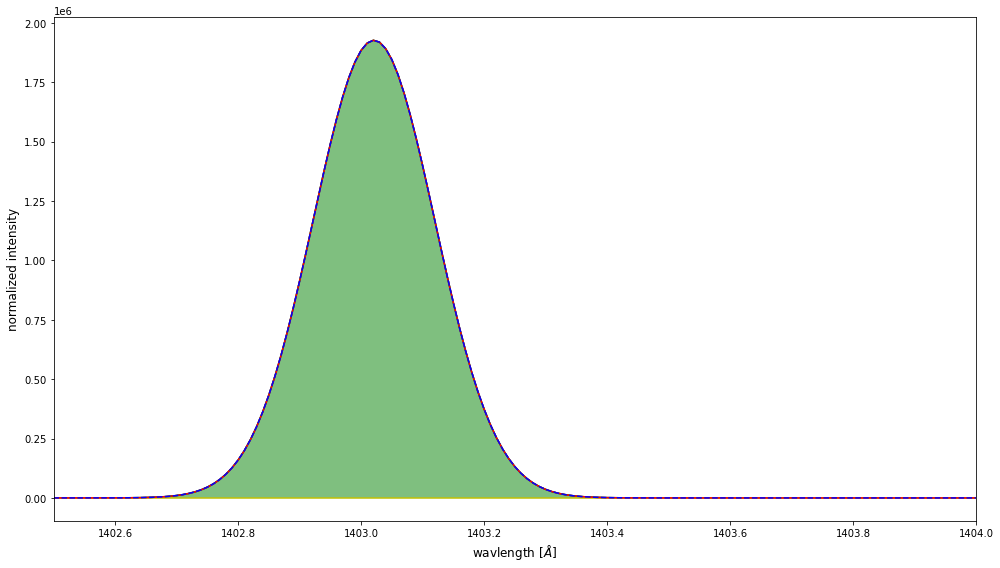

In [14]:
arrs.plotgauss(itime=6)

# Fit:

In [15]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [16]:
imax = np.argmax(arrs.vr) 

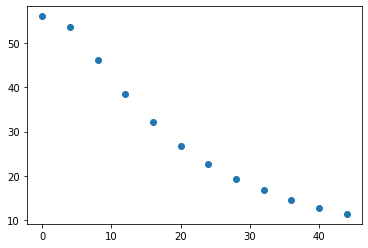

In [17]:
tt = arrs.time[imax:imax+12]
tt = tt-tt[0]
vr = arrs.vr[imax:imax+12]
plt.plot(tt,vr,'o')

In [18]:
a0= [arrs.vr[imax],6]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

In [19]:
preft_fit = u0_fit(tt,*popt)
f = interp1d(tt,preft_fit,kind='cubic')

In [20]:
tnew = np.linspace(tt[0], tt[-1], num=51, endpoint=True)

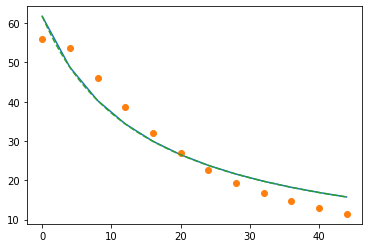

In [21]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')
plt.plot(tnew,f(tnew),'--')

In [22]:
H = 0.6*popt[0]*popt[1]
print('H = ', H)
print('tau = ',popt[1])

H =  557.6450404203762
tau =  15.049660399306465


 # Move to CCSDS time

In [23]:
import datetime
import matplotlib.dates as date

In [24]:
aiatime = readsav('/Users/WilliamHenryAshfieldIV/dat/aia2preft_ccsds.sav',verbose=False,python_dict=False)

In [25]:
aiatime

{'aiat': array([b'2014-10-25T17:04:14.630', b'2014-10-25T17:04:14.830',
        b'2014-10-25T17:04:15.030', ..., b'2014-10-25T17:34:14.230',
        b'2014-10-25T17:34:14.430', b'2014-10-25T17:34:14.630'],
       dtype=object)}

In [26]:
aiatm = np.array(aiatime.aiat)

In [27]:
aiatm = aiatm[0:900]

In [28]:
aiatm[0]

b'2014-10-25T17:04:14.630'

In [29]:
# from IRIS
# peak time = '17:05:58.473000'
# peak time in seconds: 61558.47s

In [30]:
tm = arrs.time
sttime = 61558.47-shift_time # observation start time in sec.
tm += sttime # shifts array such that peaks in IRIS and PREFT align in time.

In [31]:
dts = np.empty(len(tm), dtype = '<U15')
for i in range (0,len(tm)):
    dts[i] = str(datetime.timedelta(seconds=tm[i],milliseconds=3))

In [32]:
dts[6] # should match IRIS peak time.. 

'17:05:54.473000'

In [33]:
tmp = np.array([datetime.datetime for x in range(len(tm))])
for i in range(0,len(tm)):
    tmp[i]=datetime.datetime.strptime(dts[i],'%H:%M:%S.%f')
tm_d = date.date2num(tmp)

In [34]:
stm_d = tm_d[imax:imax+12]

(0.0, 60.0)

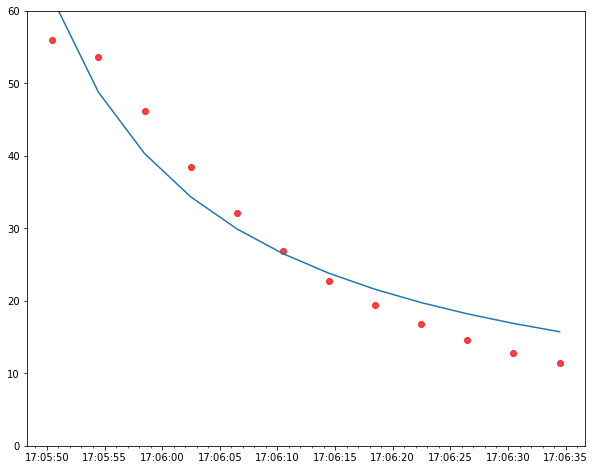

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(stm_d,vr,'r' 'o',alpha=0.75)
ax.plot_date(stm_d,u0_fit(tt,*popt),'-')
#ax.plot_date(stm_d,vb,'b',alpha=0.75,marker='o')
#ax.xaxis.set_major_locator(date.MinuteLocator())
#ax.xaxis.set_major_locator(tmp[1420:1430])
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
#ax.xaxis.set_minor_formatter(date.DateFormatter('0.%f'))
ax.set_ylim(0,60)

In [36]:
str0 = -25566.287457025464 # from fit_iris

In [37]:
stm_d[0]

-25566.287610266205

# IRIS fit data
(need to run fit_iris.ipynb first!)

In [38]:
%store -r vr_fit
%store -r vr_iris
%store -r stm

In [39]:
firis = interp1d(stm,vr_fit,kind='cubic')
tiris = np.linspace(stm[0], stm[-1], num=51, endpoint=True)

In [40]:
import matplotlib as mpl
import matplotlib.font_manager as fm
# Rebuild the matplotlib font cache
fm._rebuild()

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

clrs = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

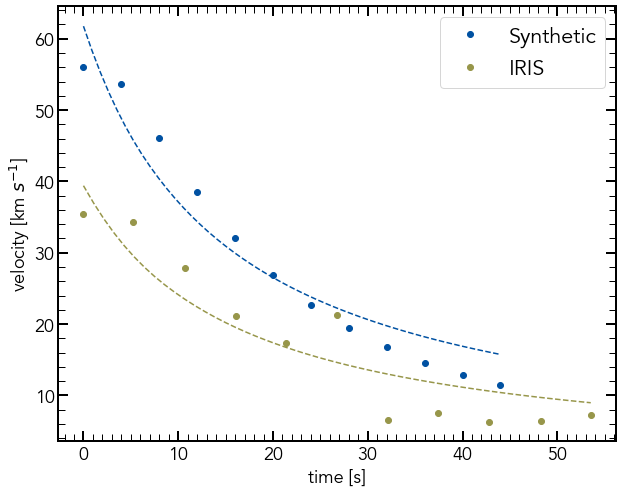

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tt,vr,'o',label='Synthetic', color = clrs[0])
ax.plot(tnew,f(tnew), '--', color = clrs[0])
ax.plot(stm,vr_iris,'o',label='IRIS', color = clrs[1])
ax.plot(tiris,firis(tiris), '--', color = clrs[1])

ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [km $s^{-1}$]')
ax.legend(fontsize='large')

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=1, direction='in', right='on')

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

#ax.set_xlim(-0.5, 40)
#ax.set_ylim(-1.5, 50)

fig.savefig('IRIS_PREFT_velocities.png', format='png',facecolor='w', edgecolor='w', dpi = 1000)

## Scaled 'data'
Corresponding to $45^\circ$ deviation from LOS

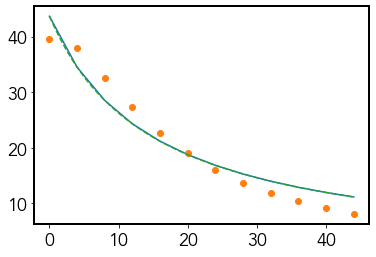

In [42]:
vr2 = arrs.vr[imax:imax+12]/np.sqrt(2)

a0= [vr2[0],6]
popt2, pcov2 = curve_fit(u0_fit, tt, vr2,p0=a0)

preft_fit2 = u0_fit(tt,*popt2)
f2 = interp1d(tt,preft_fit2,kind='cubic')

plt.plot(tt,u0_fit(tt,*popt2))
plt.plot(tt,vr2,'o')
plt.plot(tnew,f2(tnew),'--')

In [43]:
H = 0.6*popt2[0]*popt2[1]
print('H = ', H)
print('tau = ',popt2[1])

H =  394.314587430395
tau =  15.049660282335164


In [44]:
popt2[0]
vr2[0]

39.60176976463247

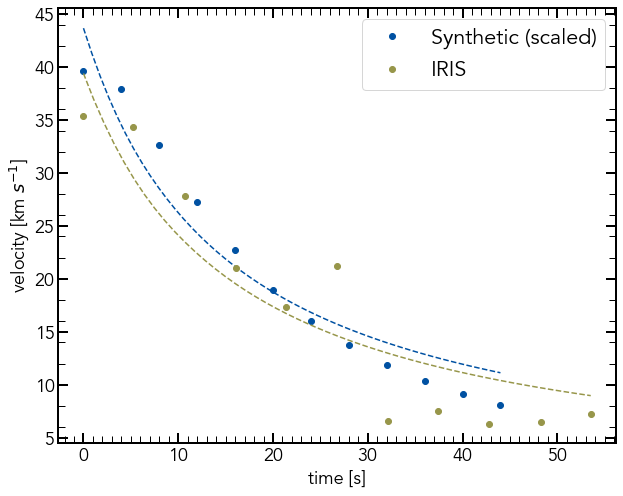

In [45]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tt,vr2,'o',label='Synthetic (scaled)', color = clrs[0])
ax.plot(tnew,f2(tnew), '--', color = clrs[0])
ax.plot(stm,vr_iris,'o',label='IRIS', color = clrs[1])
ax.plot(tiris,firis(tiris), '--', color = clrs[1])

ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [km $s^{-1}$]')
ax.legend(fontsize='large')

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=1, direction='in', right='on')

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

fig.savefig('IRIS_PREFT_velocities_scaled.png', format='png',facecolor='w', edgecolor='w', dpi = 1000)

In [46]:
sttime

61530.47

In [47]:
dts[0]

'17:05:30.473000'

In [48]:
vr_iris[0]

35.38914176203285

In [49]:
tm-=sttime

In [56]:
CBcc = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


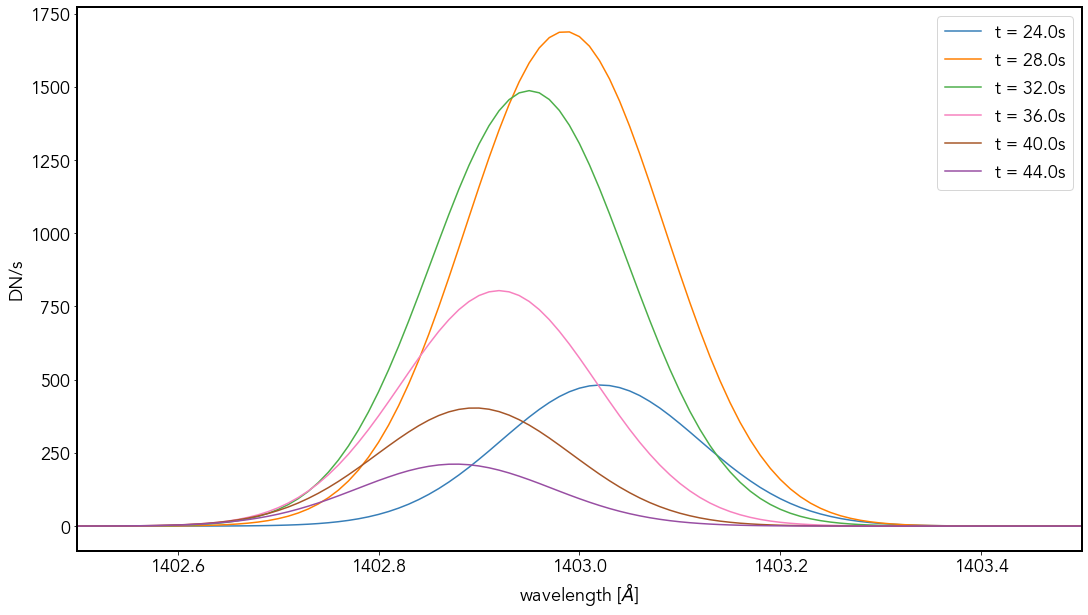

In [59]:
fig, ax = plt.subplots(figsize=[18,10])
plt.plot(ll,arrs.respec[6,:]/(4.*10**3),color = CBcc[0],label='t = '+str(tm[6])+'s')
plt.plot(ll,arrs.respec[7,:]/(4.*10**3),color = CBcc[1],label='t = '+str(tm[7])+'s')
plt.plot(ll,arrs.respec[8,:]/(4.*10**3),color = CBcc[2],label='t = '+str(tm[8])+'s')
plt.plot(ll,arrs.respec[9,:]/(4.*10**3),color = CBcc[3],label='t = '+str(tm[9])+'s')
plt.plot(ll,arrs.respec[10,:]/(4.*10**3),color = CBcc[4],label='t = '+str(tm[10])+'s')
plt.plot(ll,arrs.respec[11,:]/(4.*10**3),color = CBcc[5],label='t = '+str(tm[11])+'s')
plt.xlim(1402.5,1403.5)
plt.ylabel('DN/s')
ax.set_xlabel('wavelength [$\AA$]')
ax.legend()

fig.savefig('synth_spectrum.png', format='png',facecolor='w', edgecolor='w', dpi = 1000)

(1402.5, 1403.5)

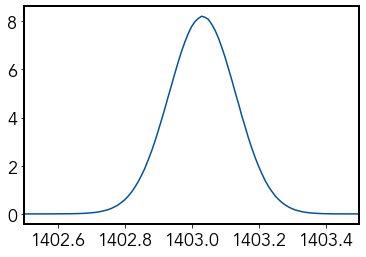

In [52]:
plt.plot(ll,arrs.respec[5,:]/(4.*10**3),color = clrs[0],label='t = '+str(tm[6])+'s')
plt.xlim(1402.5,1403.5)